# Adjoint example

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
%matplotlib inline

from __future__ import print_function

In [37]:
class model_A(object):
    
    def __init__(self, c=1, dt=0.001, N=1000):
        self.c = c
        self.dt = dt
        self.N = N
        self.t = np.arange(0, dt*N, dt)
    
    def nlm(self, u0):
        self.u0 = u0
        u = np.empty(self.N)
        u[0] = u0
        fac = self.c * self.dt
        for j in range(self.N-1):
            u[j+1] = u[j] - fac * u[j] * u[j]
        self.u = u.copy()
        return u
    
    def tlm(self, up0, nlm=None):
        if nlm is None:
            u = self.u
        else:
            u = nlm
        up = np.empty(self.N)
        up[0] = up0
        fac = self.c * self.dt
        for j in range(self.N-1):
            up[j+1] = up[j] - 2.0 * fac * u[j] * up[j]
        return up
    
    def adj(self, uhatT, nlm=None):
        if nlm is None:
            u = self.u
        else:
            u = nlm
        uhat = np.empty(self.N)
        uhat[-1] = uhatT
        fac = self.c * self.dt
        for j in range(self.N-1, 0, -1):
            uhat[j-1] = uhat[j] + 2.0 * fac * u[j-1] * uhat[j]
        return uhat


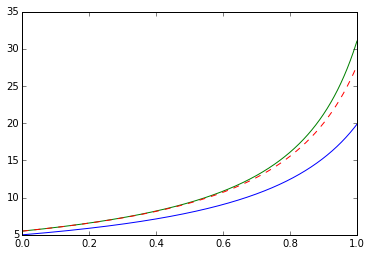

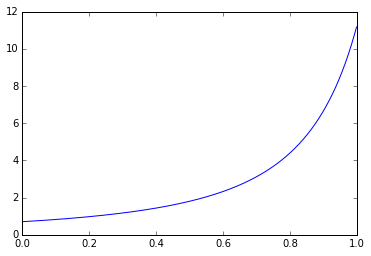

In [49]:
m = model_A(c=-0.15)
plt.figure()
plt.plot(m.t, m.nlm(5.0))
plt.plot(m.t, m.nlm(5.5))

m.nlm(5.0);
plt.plot(m.t, m.u+m.tlm(0.5), 'r--')

plt.figure()
uhat0 = m.nlm(5.5)[-1] - m.nlm(5.0)[-1] 
m.nlm(5.0);
plt.plot(m.t, m.adj(uhat0))

du = m.adj(uhat0)[0]

##Testing the TLM and ADJ models

In [42]:
def tlm_test(m, alphas, u0=1.0):
    psi = np.empty(alphas.shape)
    nlm0 = m.nlm(u0)
    for n, alpha in enumerate(alphas):
        psi[n] = (m.nlm(u0+alpha)[-1] - nlm0[-1]) / m.tlm(alpha, nlm0)[-1]
    return psi

def adj_test(m, u0=1.0, du=0.1):
    nlm = m.nlm (u0)
    tlm = m.tlm(du)
    adj = m.adj(tlm[-1])
    return tlm[-1]**2 / (du * adj[0])

In [40]:
def test(m):
    # TLM test
    print('\n### TLM test: psi -> 1.0 as alpha -> 0')
    alpha = 10.0**(-np.arange(1,11))
    psi = tlm_test(m, alpha)
    print('\n   alpha      |      psi  ')
    print(28*'-')
    for a, p in zip(alpha, psi):
        print('%10e  |  %10e' % (a, p))
    
    # ADJ test
    print('\n### Adjoint test')
    print('\n%.20f == 1.0' % adj_test(m))


In [79]:
m = model_A()
test(m)


### TLM test: psi -> 1.0 as alpha -> 0

   alpha      |      psi  
----------------------------
1.000000e-01  |  9.230189e-01
1.000000e-02  |  9.917291e-01
1.000000e-03  |  9.991667e-01
1.000000e-04  |  9.999166e-01
1.000000e-05  |  9.999917e-01
1.000000e-06  |  9.999992e-01
1.000000e-07  |  1.000000e+00
1.000000e-08  |  1.000003e+00
1.000000e-09  |  1.000038e+00
1.000000e-10  |  1.000479e+00

### Adjoint test

1.00000000000000377476 == 1.0


##Finding the optimal initial condition

Optimal IC using optimize.fmin (look, ma!  No Adjoint!)

In [75]:
model = model_A(c=0.1)
data = 1.0
u0_guess = 1.0

def cost(u0):
    "Return cost function, given an IC"
    return (model.nlm(u0)[-1] - data)**2

u0_fit = optimize.fmin(cost, (u0_guess,))
print('u0_fit = %f' % u0_fit)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 22
u0_fit = 1.111035


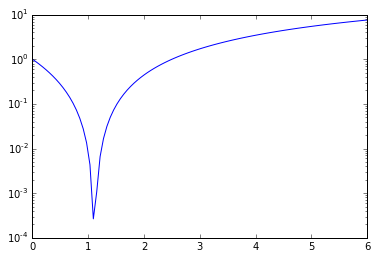

In [76]:
u0_trials = np.linspace(0, 6, 100)
J = []
for u0 in u0_trials:
    J.append(cost(u0))

plt.semilogy(u0_trials, J)


Optimal IC using `optimize.fmin_cg`

In [77]:
def Dcost(u0):
    "Return cost function gradient, given an IC"
    nlm = model.nlm(u0)
    du = nlm[-1] - data
    return model.adj(du, nlm=nlm)[0]

u0_fit = optimize.fmin_cg(cost, (u0_guess,), fprime=Dcost)
print('u0_fit = %f' % u0_fit)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
u0_fit = 1.111001
